In [1]:
import sys
import datetime as dt
import numpy    as np
import pandas   as pd
import seaborn  as sns
import matplotlib.pyplot as plt

from typing                import Tuple, List, Set, Iterable, Dict, Any, Optional, Union, Callable
from collections           import Counter

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute        import SimpleImputer
from sklearn.compose       import ColumnTransformer, make_column_selector
from sklearn.pipeline      import Pipeline

sns.set_style("darkgrid")

In [2]:
sys.path.insert(0, "../../")  # Добавляем родительскую директорию в `path`, чтобы python смог найти наши модули

In [3]:
from modules.preprocessing import MultilabelEncoder, RegexTransformer
from modules.base          import CustomTransformer
from modules.compose       import GroupByTransformer
from modules.outliers      import RangeOutlierDetector, DeltaFromMedianOutlierDetector
from modules.impute        import InterpolationImputer

<div class="alert alert-info">
  <h1><center>Data</center></h1></div>

In [4]:
df = pd.read_csv("../data/credit_score.csv", low_memory=False)
df.columns = map(str.lower, df.columns)
df["month"] = df["month"].apply(lambda val: dt.datetime.strptime(val, "%B").month)
df["credit_history_age_in_months"] = df["credit_history_age"]
df["credit_history_age_in_years"]  = df["credit_history_age"]
df = df.set_index(["customer_id", "month"]).sort_index()
df = df.drop(columns=["credit_history_age", "name", "ssn", "id"])
df.head(2)

age occupation annual_income  monthly_inhand_salary  \
customer_id month                                                       
CUS_0x1000  1      17     Lawyer      30625.94            2706.161667   
            2      17     Lawyer      30625.94                    NaN   

                   num_bank_accounts  num_credit_card  interest_rate  \
customer_id month                                                      
CUS_0x1000  1                      6                5             27   
            2                      6                5             27   

                  num_of_loan                               type_of_loan  \
customer_id month                                                          
CUS_0x1000  1               2  Credit-Builder Loan, and Home Equity Loan   
            2               2  Credit-Builder Loan, and Home Equity Loan   

                   delay_from_due_date  ... outstanding_debt  \
customer_id month                       ...                    
CUS_0x1000  1                       62  ...          1562.91   
            2                       62  ...          1562.91   

                  credit_utilization_ratio  payment_of_min_amount  \
customer_id month                                                   
CUS_0x1000  1                    26.612093                    Yes   
            2                    29.439759                    Yes   

                  total_emi_per_month amount_invested_monthly  \
customer_id month                                               
CUS_0x1000  1                42.94109      244.75028300769162   
            2                42.94109      176.13256665597928   

                                 payment_behaviour    monthly_balance  \
customer_id month                                                       
CUS_0x1000  1       Low_spent_Large_value_payments  252.9247932365056   
            2      High_spent_Small_value_payments   311.542509588218   

                   credit_score credit_history_age_in_months  \
customer_id month                                              
CUS_0x1000  1          Standard        10 Years and 2 Months   
            2              Poor        10 Years and 3 Months   

                  credit_history_age_in_years  
customer_id month                              
CUS_0x1000  1           10 Years and 2 Months  
            2           10 Years and 3 Months  

[2 rows x 24 columns]

In [5]:
X = df.drop(columns=["credit_score"])
y = df["credit_score"]

---

### Train-Test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
cids = sorted(set(y.index.get_level_values("customer_id")))

In [8]:
train_cids, test_cids = train_test_split(cids, test_size=0.2, random_state=42)

In [9]:
ind_train = X.index.get_level_values("customer_id").isin(train_cids)
ind_test  = X.index.get_level_values("customer_id").isin(test_cids)

In [10]:
X_train = X.loc[ind_train]
y_train = y.loc[ind_train]
X_test  = X.loc[ind_test]
y_test  = y.loc[ind_test]

In [11]:
pd.DataFrame({"train": y_train.value_counts(normalize=True), "test": y_test.value_counts(normalize=True)})

,train,test
Standard,0.532425,0.5290
Poor,0.290900,0.2863
Good,0.176675,0.1847


<div class="alert alert-info">
  <h1><center>Pipeline</center></h1></div>

### CustomTransformer

In [12]:
from typing import List
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


class CustomTransformer(BaseEstimator, TransformerMixin):

    def __init__(self) -> None:
        self.feature_names_in_: List[str]
        self.n_features_ : int
        self.is_fitted_: bool

    def fit(self, X, y=None, **params) -> 'CustomTransformer':
        self.feature_names_in_ = list(X.columns)
        self.n_features_ = X.shape[1]
        self.is_fitted_ = True
        return self

    def transform(self, X, copy: bool = False, **params):
        check_is_fitted(self, 'is_fitted_')
        if copy:
            X = X.copy()
        return X

    def get_feature_names_out(self, input_features=None) -> List[str]:
        return self.feature_names_in_

### RegexTransformer

In [13]:
import warnings
import numpy as np
import pandas as pd
from typing import List, Dict, Any, Optional
from itertools import chain

In [26]:
class RegexTransformer(CustomTransformer):

    def __init__(
            self,
            replace      : Optional[Dict[str, Optional[str]]] = None,
            find         : Optional[str] = None,
            split        : Optional[str] = None,
            target_dtype : Optional[type] = None,
            get_first    : bool = True,
        ):
        self.replace = replace
        self.find = find
        self.split = split
        self.target_dtype = target_dtype
        self.get_first = get_first

    def transform(self, X: pd.DataFrame, **params):
        X = super().transform(X)
        X = pd.concat(
                        [
                            self._process_series(column_values)
                            for _, column_values
                            in X.items()
                        ],
                        axis=1
                    )
        return X.values

    def _process_series(self, series: pd.Series) -> pd.Series:
        if self.replace is not None:
            for pat, repl in self.replace.items():
                if repl is None:
                    repl = lambda val: np.nan
                series = series.str.replace(pat, repl, case=False, regex=True)
        if self.find is not None:
            series = series.str.findall(self.find)
        if self.split is not None:
            series = series.str.split(self.split, regex=True)
        if self.get_first:
            series = series.str[0]
        if self.target_dtype is not None:
            series = series.astype(self.target_dtype)
        return series

In [27]:
rt = RegexTransformer(find="[a-zA-Z]+\_?\w+", replace={"_{2,}": ""})
rt.set_output(transform="pandas")

RegexTransformer(find='[a-zA-Z]+\\_?\\w+', replace={'_{2,}': ''})

In [28]:
X["occupation"].str.replace("_{2,}", "", case=False, regex=True)\
.str.findall("[a-zA-Z]+\_?\w+")\
.str[0]

customer_id  month
CUS_0x1000   1           Lawyer
             2           Lawyer
             3           Lawyer
             4           Lawyer
             5           Lawyer
                        ...    
CUS_0xffd    4        Scientist
             5              NaN
             6        Scientist
             7        Scientist
             8        Scientist
Name: occupation, Length: 100000, dtype: object

### Data Types Normalization

In [29]:
from typing import List, Tuple

class CustomColumnTransformer(CustomTransformer):

    def __init__(self, transformers: List[Tuple[str, TransformerMixin, List[str]]]):
        super().__init__()
        self.transformers = transformers

    def fit(self, X: pd.DataFrame, y=None, **params):
        super().fit(X=X, y=y, **params)
        for name, transformer, columns in self.transformers:
            transformer.fit(X[columns])
        return self

    def transform(self, X: pd.DataFrame, **params):
        super().transform(X=X, **params)
        results = []
        
        for name, transformer, columns in self.transformers:
            transformer_result = transformer.transform(X=X[columns], **params)
            results.append(transformer_result)
        
        return np.concatenate(results, axis=1)
        

In [30]:
cct = CustomColumnTransformer(
    transformers=[
        (
            "integers",
            RegexTransformer(find="-?\d+", target_dtype=float),
            ["age", "num_of_delayed_payment", "num_of_loan", ]
        ),
        (
            "floats",
            RegexTransformer(find="-?[\d\.]+", target_dtype=float),
            ["annual_income", "amount_invested_monthly", "changed_credit_limit", "monthly_balance", "outstanding_debt"]
        ),]
)
cct.set_output(transform="pandas")

CustomColumnTransformer(transformers=[('integers',
                                       RegexTransformer(find='-?\\d+',
                                                        target_dtype=<class 'float'>),
                                       ['age', 'num_of_delayed_payment',
                                        'num_of_loan']),
                                      ('floats',
                                       RegexTransformer(find='-?[\\d\\.]+',
                                                        target_dtype=<class 'float'>),
                                       ['annual_income',
                                        'amount_invested_monthly',
                                        'changed_credit_limit',
                                        'monthly_balance',
                                        'outstanding_debt'])])

In [31]:
cct.fit_transform(X=X[["age", "num_of_delayed_payment", "num_of_loan", "annual_income", "amount_invested_monthly", "changed_credit_limit", "monthly_balance", "outstanding_debt"]])

age  num_of_delayed_payment  num_of_loan  annual_income  \
customer_id month                                                             
CUS_0x1000  1      17.0                    25.0          2.0       30625.94   
            2      17.0                    23.0          2.0       30625.94   
            3      17.0                    28.0          2.0       30625.94   
            4      17.0                    25.0          2.0       30625.94   
            5      17.0                    25.0          2.0       30625.94   
...                 ...                     ...          ...            ...   
CUS_0xffd   4      29.0                    12.0       -100.0       41398.44   
            5      29.0                     NaN          6.0       41398.44   
            6      29.0                    12.0          6.0       41398.44   
            7      30.0                    12.0          6.0       41398.44   
            8      30.0                    11.0          6.0       41398.44   

                   amount_invested_monthly  changed_credit_limit  \
customer_id month                                                  
CUS_0x1000  1                   244.750283                  1.63   
            2                   176.132567                  1.63   
            3                   109.056519                  1.63   
            4                    87.909909                  1.63   
            5                   191.834767                  2.63   
...                                    ...                   ...   
CUS_0xffd   4                   234.354940                 10.07   
            5                   104.629474                 10.07   
            6                    47.007379                 10.07   
            7                   257.989694                 10.07   
            8                    42.575720                 12.07   

                   monthly_balance  outstanding_debt  
customer_id month                                     
CUS_0x1000  1           252.924793           1562.91  
            2           311.542510           1562.91  
            3           368.618557           1562.91  
            4           419.765167           1562.91  
            5           305.840309           1562.91  
...                            ...               ...  
CUS_0xffd   4           247.655411           1701.88  
            5           337.380877           1701.88  
            6           395.002972           1701.88  
            7           194.020657           1701.88  
            8           389.434631           1701.88  

[100000 rows x 8 columns]

In [32]:
dtype_transformer = ColumnTransformer(
    transformers=[
        (
            "integers",
            RegexTransformer(find="-?\d+", target_dtype=float),
            ["age", "num_of_delayed_payment", "num_of_loan", ]
        ),
        (
            "floats",
            RegexTransformer(find="-?[\d\.]+", target_dtype=float),
            ["annual_income", "amount_invested_monthly", "changed_credit_limit", "monthly_balance", "outstanding_debt"]
        ),
        (
            "strings",
            RegexTransformer(find="\w+\_?\w+", replace={"_{2,}": ""}, target_dtype=str),
            ["credit_mix", "occupation",]
        ),
        (
            "credit_history_years",
            RegexTransformer(find=r"\d+(?=\sYear)", target_dtype=float),
            ["credit_history_age_in_years"]
        ),
        (
            "credit_history_months",
            RegexTransformer(find=r"\d+(?=\sMonth)", target_dtype=float),
            ["credit_history_age_in_months"]
        ),
        (
            "payment_behaviour",
            RegexTransformer(replace={"!@9#%8": None}, get_first=False),
            ["payment_behaviour"]
        ),
        (
            "type_of_loan",
            RegexTransformer(replace={r"\sLoan|\sand":""}, get_first=False),
            ["type_of_loan"]
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

dtype_transformer.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('integers',
                                 RegexTransformer(find='-?\\d+',
                                                  target_dtype=<class 'float'>),
                                 ['age', 'num_of_delayed_payment',
                                  'num_of_loan']),
                                ('floats',
                                 RegexTransformer(find='-?[\\d\\.]+',
                                                  target_dtype=<class 'float'>),
                                 ['annual_income', 'amount_invested_monthly',
                                  'changed_credit_limit', 'monthly_balance',
                                  'outstanding_de...
                                ('credit_history_months',
                                 RegexTransformer(find='\\d+(?=\\sMonth)',
                                                  target_dtype=<class 'float'>),
                                 ['credit_history_age_in_months']),
                                ('payment_behaviour',
                                 RegexTransformer(get_first=False,
                                                  replace={'!@9#%8': None}),
                                 ['payment_behaviour']),
                                ('type_of_loan',
                                 RegexTransformer(get_first=False,
                                                  replace={'\\sLoan|\\sand': ''}),
                                 ['type_of_loan'])],
                  verbose_feature_names_out=False)

In [33]:
X_dtype = dtype_transformer.fit_transform(X)

### Preprocessing

#### Categorical Encoding

In [34]:
categorical_transformer = ColumnTransformer(
    transformers=[
        (
            "ordinal",
            OrdinalEncoder(categories=[["Bad", "Standard", "Good"]], handle_unknown="use_encoded_value", unknown_value=-1),
            ["credit_mix"]
        ),
        (
            "onehot",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            ["occupation", "payment_of_min_amount"]
        ),
        (
            "payment_behaviour",
            MultilabelEncoder(split_by=r"(?<=spent)\_"),
            ["payment_behaviour"]
        ),
        (
            "type_of_loan",
            MultilabelEncoder(split_by=", "),
            ["type_of_loan"]
        ),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

categorical_transformer

ColumnTransformer(transformers=[('ordinal',
                                 OrdinalEncoder(categories=[['Bad', 'Standard',
                                                             'Good']],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['credit_mix']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['occupation', 'payment_of_min_amount']),
                                ('payment_behaviour',
                                 MultilabelEncoder(split_by='(?<=spent)\\_'),
                                 ['payment_behaviour']),
                                ('type_of_loan',
                                 MultilabelEncoder(split_by=', '),
                                 ['type_of_loan'])],
                  verbose_feature_names_out=False)

#### Numerical: Outliers and Missing Values

In [35]:
outlier_transformer = ColumnTransformer(
    transformers=[
        (
            "range_0_100",
            RangeOutlierDetector(0, 100),
            ["age", "num_of_delayed_payment", "num_of_loan"]
        ),
        (
            "changed_credit_limit",
            RangeOutlierDetector(-10, 37),
            ["changed_credit_limit", ]
        ),
        (
            "delta",
            DeltaFromMedianOutlierDetector(delta=3),
            ["annual_income", "amount_invested_monthly", "monthly_balance", "monthly_inhand_salary", "total_emi_per_month"]
        ),
        (
            "range_0_10_clip",
            RangeOutlierDetector(0, 40, clip=True),
            ["num_bank_accounts", "num_credit_card", "interest_rate", "num_credit_inquiries"]
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

outlier_transformer.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('range_0_100',
                                 RangeOutlierDetector(max_value=100,
                                                      min_value=0),
                                 ['age', 'num_of_delayed_payment',
                                  'num_of_loan']),
                                ('changed_credit_limit',
                                 RangeOutlierDetector(max_value=37,
                                                      min_value=-10),
                                 ['changed_credit_limit']),
                                ('delta', DeltaFromMedianOutlierDetector(),
                                 ['annual_income', 'amount_invested_monthly',
                                  'monthly_balance', 'monthly_inhand_salary',
                                  'total_emi_per_month']),
                                ('range_0_10_clip',
                                 RangeOutlierDetector(clip=True, max_value=40,
                                                      min_value=0),
                                 ['num_bank_accounts', 'num_credit_card',
                                  'interest_rate', 'num_credit_inquiries'])],
                  verbose_feature_names_out=False)

In [36]:
imputer_transformer = ColumnTransformer(
    transformers=[
        (
            "zero_values",
            SimpleImputer(strategy="constant", fill_value=0),
            ["credit_history_age_in_years", "credit_history_age_in_months"]
        )
    ],
    remainder=InterpolationImputer(),
    verbose_feature_names_out=False,
)

imputer_transformer.set_output(transform="pandas")

ColumnTransformer(remainder=InterpolationImputer(),
                  transformers=[('zero_values',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['credit_history_age_in_years',
                                  'credit_history_age_in_months'])],
                  verbose_feature_names_out=False)

In [37]:
outlier_transformer.fit(X_dtype.select_dtypes(np.number).head(1000))

ColumnTransformer(remainder='passthrough',
                  transformers=[('range_0_100',
                                 RangeOutlierDetector(max_value=100,
                                                      min_value=0),
                                 ['age', 'num_of_delayed_payment',
                                  'num_of_loan']),
                                ('changed_credit_limit',
                                 RangeOutlierDetector(max_value=37,
                                                      min_value=-10),
                                 ['changed_credit_limit']),
                                ('delta', DeltaFromMedianOutlierDetector(),
                                 ['annual_income', 'amount_invested_monthly',
                                  'monthly_balance', 'monthly_inhand_salary',
                                  'total_emi_per_month']),
                                ('range_0_10_clip',
                                 RangeOutlierDetector(clip=True, max_value=40,
                                                      min_value=0),
                                 ['num_bank_accounts', 'num_credit_card',
                                  'interest_rate', 'num_credit_inquiries'])],
                  verbose_feature_names_out=False)

In [38]:
X_with_detected_outliers = outlier_transformer.fit_transform(X_dtype.select_dtypes(np.number).head(1000))
X_with_detected_outliers

age  num_of_delayed_payment  num_of_loan  \
customer_id month                                              
CUS_0x1000  1      17.0                    25.0          2.0   
            2      17.0                    23.0          2.0   
            3      17.0                    28.0          2.0   
            4      17.0                    25.0          2.0   
            5      17.0                    25.0          2.0   
...                 ...                     ...          ...   
CUS_0x122f  4      24.0                    17.0          9.0   
            5      24.0                    17.0          9.0   
            6      24.0                    17.0          9.0   
            7      24.0                    17.0          9.0   
            8       NaN                    17.0          9.0   

                   changed_credit_limit  annual_income  \
customer_id month                                        
CUS_0x1000  1                      1.63       30625.94   
            2                      1.63       30625.94   
            3                      1.63       30625.94   
            4                      1.63       30625.94   
            5                      2.63       30625.94   
...                                 ...            ...   
CUS_0x122f  4                      1.83       18231.52   
            5                      1.83       18231.52   
            6                      1.83       18231.52   
            7                      1.83       18231.52   
            8                      1.83       18231.52   

                   amount_invested_monthly  monthly_balance  \
customer_id month                                             
CUS_0x1000  1                   244.750283       252.924793   
            2                   176.132567       311.542510   
            3                   109.056519       368.618557   
            4                    87.909909       419.765167   
            5                   191.834767       305.840309   
...                                    ...              ...   
CUS_0x122f  4                    66.324754       271.895932   
            5                    96.458788       241.761898   
            6                   141.011014       207.209673   
            7                   108.747501       239.473185   
            8                   102.260566       245.960120   

                   monthly_inhand_salary  total_emi_per_month  \
customer_id month                                               
CUS_0x1000  1                2706.161667            42.941090   
            2                        NaN            42.941090   
            3                2706.161667            42.941090   
            4                2706.161667            42.941090   
            5                2706.161667            42.941090   
...                                  ...                  ...   
CUS_0x122f  4                        NaN            86.608647   
            5                1448.293333            86.608647   
            6                1448.293333            86.608647   
            7                1448.293333            86.608647   
            8                1448.293333            86.608647   

                   num_bank_accounts  num_credit_card  interest_rate  \
customer_id month                                                      
CUS_0x1000  1                      6                5             27   
            2                      6                5             27   
            3                      6                5             27   
            4                      6                5             27   
            5                      6                5             27   
...                              ...              ...            ...   
CUS_0x122f  4                      6                5             15   
            5                      6                5             40   
            6                      6          

In [39]:
X_without_outliers = imputer_transformer.fit_transform(X_with_detected_outliers)
X_without_outliers.isna().mean()

credit_history_age_in_years     0.0
credit_history_age_in_months    0.0
age                             0.0
num_of_delayed_payment          0.0
num_of_loan                     0.0
changed_credit_limit            0.0
annual_income                   0.0
amount_invested_monthly         0.0
monthly_balance                 0.0
monthly_inhand_salary           0.0
total_emi_per_month             0.0
num_bank_accounts               0.0
num_credit_card                 0.0
interest_rate                   0.0
num_credit_inquiries            0.0
outstanding_debt                0.0
delay_from_due_date             0.0
credit_utilization_ratio        0.0
dtype: float64

In [40]:
class CustomPipeline(CustomTransformer):

    def __init__(self, steps: List[Tuple[str, TransformerMixin]]):
        self.steps = steps

    def fit(self, X: pd.DataFrame, y=None, **params):
        for name, transformer in self.steps[:-1]:
            X = transformer.fit_transform(X, y, **params)
            
        name, transformer = self.steps[-1]
        transformer.fit(X, y, **params)
        return self

    def transform(self, X: pd.DataFrame, **params):
        X = X.copy()
        for name, transformer in self.steps:
            print(name.center(40, "-"))
            X = transformer.transform(X, **params)
            display(X.info())

        return X


In [41]:
cp = CustomPipeline([
        ("outliers", outlier_transformer),
        ("imputer", imputer_transformer)
]).set_output(transform="pandas")
cp

CustomPipeline(steps=[('outliers',
                       ColumnTransformer(remainder='passthrough',
                                         transformers=[('range_0_100',
                                                        RangeOutlierDetector(max_value=100,
                                                                             min_value=0),
                                                        ['age',
                                                         'num_of_delayed_payment',
                                                         'num_of_loan']),
                                                       ('changed_credit_limit',
                                                        RangeOutlierDetector(max_value=37,
                                                                             min_value=-10),
                                                        ['changed_credit_limit']),
                                                       ('delta',
                                                        DeltaFromMedianOutlierDetector(),
                                                        ['annual...
                                                        ['num_bank_accounts',
                                                         'num_credit_card',
                                                         'interest_rate',
                                                         'num_credit_inquiries'])],
                                         verbose_feature_names_out=False)),
                      ('imputer',
                       ColumnTransformer(remainder=InterpolationImputer(),
                                         transformers=[('zero_values',
                                                        SimpleImputer(fill_value=0,
                                                                      strategy='constant'),
                                                        ['credit_history_age_in_years',
                                                         'credit_history_age_in_months'])],
                                         verbose_feature_names_out=False))])

In [42]:
cp.fit(X_dtype.select_dtypes(np.number).head(1000))

CustomPipeline(steps=[('outliers',
                       ColumnTransformer(remainder='passthrough',
                                         transformers=[('range_0_100',
                                                        RangeOutlierDetector(max_value=100,
                                                                             min_value=0),
                                                        ['age',
                                                         'num_of_delayed_payment',
                                                         'num_of_loan']),
                                                       ('changed_credit_limit',
                                                        RangeOutlierDetector(max_value=37,
                                                                             min_value=-10),
                                                        ['changed_credit_limit']),
                                                       ('delta',
                                                        DeltaFromMedianOutlierDetector(),
                                                        ['annual...
                                                        ['num_bank_accounts',
                                                         'num_credit_card',
                                                         'interest_rate',
                                                         'num_credit_inquiries'])],
                                         verbose_feature_names_out=False)),
                      ('imputer',
                       ColumnTransformer(remainder=InterpolationImputer(),
                                         transformers=[('zero_values',
                                                        SimpleImputer(fill_value=0,
                                                                      strategy='constant'),
                                                        ['credit_history_age_in_years',
                                                         'credit_history_age_in_months'])],
                                         verbose_feature_names_out=False))])

In [43]:
pipe = Pipeline([
        ("outliers", outlier_transformer),
        ("imputer", imputer_transformer)
    ])
pipe.set_output(transform="pandas")

Pipeline(steps=[('outliers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('range_0_100',
                                                  RangeOutlierDetector(max_value=100,
                                                                       min_value=0),
                                                  ['age',
                                                   'num_of_delayed_payment',
                                                   'num_of_loan']),
                                                 ('changed_credit_limit',
                                                  RangeOutlierDetector(max_value=37,
                                                                       min_value=-10),
                                                  ['changed_credit_limit']),
                                                 ('delta',
                                                  DeltaFromMedianOutlierDetector(),
                                                  ['annual_incom...
                                                  ['num_bank_accounts',
                                                   'num_credit_card',
                                                   'interest_rate',
                                                   'num_credit_inquiries'])],
                                   verbose_feature_names_out=False)),
                ('imputer',
                 ColumnTransformer(remainder=InterpolationImputer(),
                                   transformers=[('zero_values',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['credit_history_age_in_years',
                                                   'credit_history_age_in_months'])],
                                   verbose_feature_names_out=False))])

In [44]:
pipe["imputer"]

ColumnTransformer(remainder=InterpolationImputer(),
                  transformers=[('zero_values',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['credit_history_age_in_years',
                                  'credit_history_age_in_months'])],
                  verbose_feature_names_out=False)

### GroupBy Transformer

In [ ]:
import numpy as np
import pandas as pd
from typing import Union, Iterable, Dict, TypeAlias
from copy import deepcopy
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from .base import CustomTransformer

In [ ]:
GroupTransformer: TypeAlias = Union[CustomTransformer, ColumnTransformer, Pipeline]

In [46]:
X_dtype.head(2)

age  num_of_delayed_payment  num_of_loan  annual_income  \
customer_id month                                                             
CUS_0x1000  1      17.0                    25.0          2.0       30625.94   
            2      17.0                    23.0          2.0       30625.94   

                   amount_invested_monthly  changed_credit_limit  \
customer_id month                                                  
CUS_0x1000  1                   244.750283                  1.63   
            2                   176.132567                  1.63   

                   monthly_balance  outstanding_debt credit_mix occupation  \
customer_id month                                                            
CUS_0x1000  1           252.924793           1562.91        Bad     Lawyer   
            2           311.542510           1562.91        Bad     Lawyer   

                   ...                 type_of_loan  monthly_inhand_salary  \
customer_id month  ...                                                       
CUS_0x1000  1      ...  Credit-Builder, Home Equity            2706.161667   
            2      ...  Credit-Builder, Home Equity                    NaN   

                  num_bank_accounts num_credit_card  interest_rate  \
customer_id month                                                    
CUS_0x1000  1                     6               5             27   
            2                     6               5             27   

                   delay_from_due_date  num_credit_inquiries  \
customer_id month                                              
CUS_0x1000  1                       62                  10.0   
            2                       62                  11.0   

                   credit_utilization_ratio  payment_of_min_amount  \
customer_id month                                                    
CUS_0x1000  1                     26.612093                    Yes   
            2                     29.439759                    Yes   

                   total_emi_per_month  
customer_id month                       
CUS_0x1000  1                 42.94109  
            2                 42.94109  

[2 rows x 23 columns]

In [ ]:
class GroupByTransformer(CustomTransformer):
    
    def __init__(
            self,
            groupby: Union[str, Iterable],
            transformer: GroupTransformer,
            stateless: bool = False,
        ):
        super().__init__()
        self.groupby = groupby
        self.transformer = transformer
        self.stateless = stateless
        self._output_as_dataframe: bool = False
        self.transformers_: Dict[str, GroupTransformer]

    def set_output(self, *, transform=None):
        self._output_as_dataframe = transform == "pandas"
        self.transformer.set_output(transform=transform)
        return self

    def fit(self, X: pd.DataFrame, **params):
        super().fit(X, **params)
        if not self.stateless:
            self.transformers_ = {
                                    group_name: deepcopy(self.transformer).fit(group_values, **params)
                                    for group_name, group_values
                                    in X.groupby(self.groupby)
                                }
        return self
    
    def transform(self, X: pd.DataFrame, **params):
        X = super().transform(X, copy=True, **params)
        # Temporary add row_id to X:
        X.index = pd.MultiIndex.from_frame(X.index.to_frame().assign(temp__row_id=np.arange(len(X))))
        X_transformed = pd.concat([
                                    self._transform_group(group_name, group_values, **params)
                                    for group_name, group_values
                                    in X.groupby(self.groupby, group_keys=True, as_index=False)
                                ])
        # Return to original order:
        X_transformed = X_transformed.sort_index("temp__row_id")
        # Drop temporary row_id:
        X_transformed.index = X_transformed.index.droplevel("temp__row_id")
        if self._output_as_dataframe:
            return X_transformed
        else:
            return X_transformed.values

    def _transform_group(self, group_name: str, group_values: pd.DataFrame, **params) -> pd.DataFrame:
        if self.stateless:
            values = deepcopy(self.transformer).fit_transform(group_values, **params)
        else:
            values = self.transformers_[group_name].transform(group_values, **params)
        if isinstance(values, np.ndarray):
            values = pd.DataFrame(values, columns=group_values.columns)
        values.index = group_values.index
        return values


In [50]:
tmp = X_dtype.sample(frac=1).copy()

In [ ]:
X.index = pd.MultiIndex.from_frame(X.index.to_frame().assign(temp__row_id=np.arange(len(X))))

In [57]:
ind = tmp.index.to_frame().assign(temp__row_id=np.arange(len(tmp)))
ind.head(2)

,,customer_id,month,temp__row_id
customer_id,month,,,
CUS_0xc56a,2,CUS_0xc56a,2,0
CUS_0x9614,4,CUS_0x9614,4,1


In [60]:
tmp.index = pd.MultiIndex.from_frame(ind)

In [61]:
tmp.head()

,,,age,num_of_delayed_payment,num_of_loan,annual_income,amount_invested_monthly,changed_credit_limit,monthly_balance,outstanding_debt,credit_mix,occupation,...,type_of_loan,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,delay_from_due_date,num_credit_inquiries,credit_utilization_ratio,payment_of_min_amount,total_emi_per_month
customer_id,month,temp__row_id,,,,,,,,,,,,,,,,,,,,,
CUS_0xc56a,2,0,27.0,10.0,2.0,15985.290,119.402018,11.85,282.251183,1336.47,Standard,Developer,...,"Not Specified, Personal",1210.985828,6,10,26,30,15.0,36.961088,Yes,101.979221
CUS_0x9614,4,1,28.0,24.0,5.0,8044.130,40.341315,5.86,256.490187,2511.75,Bad,Architect,...,"Not Specified, Not Specified, Mortgage, Home E...",396.344167,7,7,29,48,7.0,31.036534,NM,32.802915
CUS_0xb86b,1,2,29.0,11.0,4.0,14656.680,136.736769,13.96,261.945163,1395.09,Standard,Accountant,...,"Home Equity, Credit-Builder, Home Equity, Debt...",1410.390000,6,6,15,16,7.0,35.725999,Yes,32.357068
CUS_0x32a7,8,3,44.0,8.0,6.0,10460.245,67.541992,19.09,283.750488,2625.88,Standard,Journalist,...,"Credit-Builder, Credit-Builder, Student, Mortg...",NaN,8,5,25,8,8.0,35.429605,Yes,38.276229
CUS_0x5b9d,3,4,45.0,23.0,1.0,87966.960,223.799276,14.24,728.308529,166.72,nan,Mechanic,...,Student,NaN,5,2,15,12,1.0,29.975365,Yes,64.350195


---

In [16]:
numerical_transformer = GroupByTransformer(
    transformer=Pipeline([
        ("outliers", outlier_transformer),
        ("imputer", imputer_transformer)
    ]),
    groupby="customer_id",
    stateless=True
)

numerical_transformer

GroupByTransformer(groupby='customer_id', stateless=True,
                   transformer=Pipeline(steps=[('outliers',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('range_0_100',
                                                                                 RangeOutlierDetector(max_value=100,
                                                                                                      min_value=0),
                                                                                 ['age',
                                                                                  'num_of_delayed_payment',
                                                                                  'num_of_loan']),
                                                                                ('changed_credit_limit',
                                                                                 RangeOutlierDetector(max_value=37,
                                                                                                      min_value=-10),
                                                                                 ['changed_cred...
                                                                                 ['num_bank_accounts',
                                                                                  'num_credit_card',
                                                                                  'interest_rate',
                                                                                  'num_credit_inquiries'])],
                                                                  verbose_feature_names_out=False)),
                                               ('imputer',
                                                ColumnTransformer(remainder=InterpolationImputer(),
                                                                  transformers=[('zero_values',
                                                                                 SimpleImputer(fill_value=0,
                                                                                               strategy='constant'),
                                                                                 ['credit_history_age_in_years',
                                                                                  'credit_history_age_in_months'])],
                                                                  verbose_feature_names_out=False))]))

#### Full preprocessing pipeline

In [17]:
processing_transformer = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, make_column_selector(dtype_include="object")),
        ("numerical", numerical_transformer, make_column_selector(dtype_include=np.number))
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

processing_transformer

ColumnTransformer(transformers=[('categorical',
                                 ColumnTransformer(transformers=[('ordinal',
                                                                  OrdinalEncoder(categories=[['Bad',
                                                                                              'Standard',
                                                                                              'Good']],
                                                                                 handle_unknown='use_encoded_value',
                                                                                 unknown_value=-1),
                                                                  ['credit_mix']),
                                                                 ('onehot',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                sparse_output=False),
                                                                  ['occupation',
                                                                   'payment_of_min_amount']),
                                                                 ('payment_behaviour',
                                                                  Multila...
                                                                                ('imputer',
                                                                                 ColumnTransformer(remainder=InterpolationImputer(),
                                                                                                   transformers=[('zero_values',
                                                                                                                  SimpleImputer(fill_value=0,
                                                                                                                                strategy='constant'),
                                                                                                                  ['credit_history_age_in_years',
                                                                                                                   'credit_history_age_in_months'])],
                                                                                                   verbose_feature_names_out=False))])),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A849ABDE10>)],
                  verbose_feature_names_out=False)

### Complete Pipeline

In [18]:
pipe = Pipeline([
    ("dtypes_converter", dtype_transformer),
    ("preprocessing", processing_transformer)
])

pipe.set_output(transform="pandas")

Pipeline(steps=[('dtypes_converter',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('integers',
                                                  RegexTransformer(find='-?\\d+',
                                                                   target_dtype=<class 'float'>),
                                                  ['age',
                                                   'num_of_delayed_payment',
                                                   'num_of_loan']),
                                                 ('floats',
                                                  RegexTransformer(find='-?[\\d\\.]+',
                                                                   target_dtype=<class 'float'>),
                                                  ['annual_income',
                                                   'amount_invested_monthly',
                                                   'changed_credit_limi...
                                                                                                  ColumnTransformer(remainder=InterpolationImputer(),
                                                                                                                    transformers=[('zero_values',
                                                                                                                                   SimpleImputer(fill_value=0,
                                                                                                                                                 strategy='constant'),
                                                                                                                                   ['credit_history_age_in_years',
                                                                                                                                    'credit_history_age_in_months'])],
                                                                                                                    verbose_feature_names_out=False))])),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A849ABDE10>)],
                                   verbose_feature_names_out=False))])

---

In [21]:
X_train_transformed = pipe.fit_transform(X_train)
X_test_transformed = pipe.transform(X_test)

In [19]:
import joblib

In [22]:
joblib.dump(pipe, "../files/credit_score_pipeline.pickle")

['../files/credit_score_pipeline.pickle']

---

<div class="alert alert-info">
  <h1><center>Decision Tree Classifier</center></h1></div>

### Model

In [18]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [19]:
classifier = DecisionTreeClassifier(random_state=1)
classifier.fit(X_train_transformed, y_train)

DecisionTreeClassifier(random_state=1)

In [20]:
classifier.tree_.n_leaves

14063

In [21]:
classifier.tree_.max_depth

42

In [26]:
classifier.classes_

array(['Good', 'Poor', 'Standard'], dtype=object)

#### Plot decision tree:

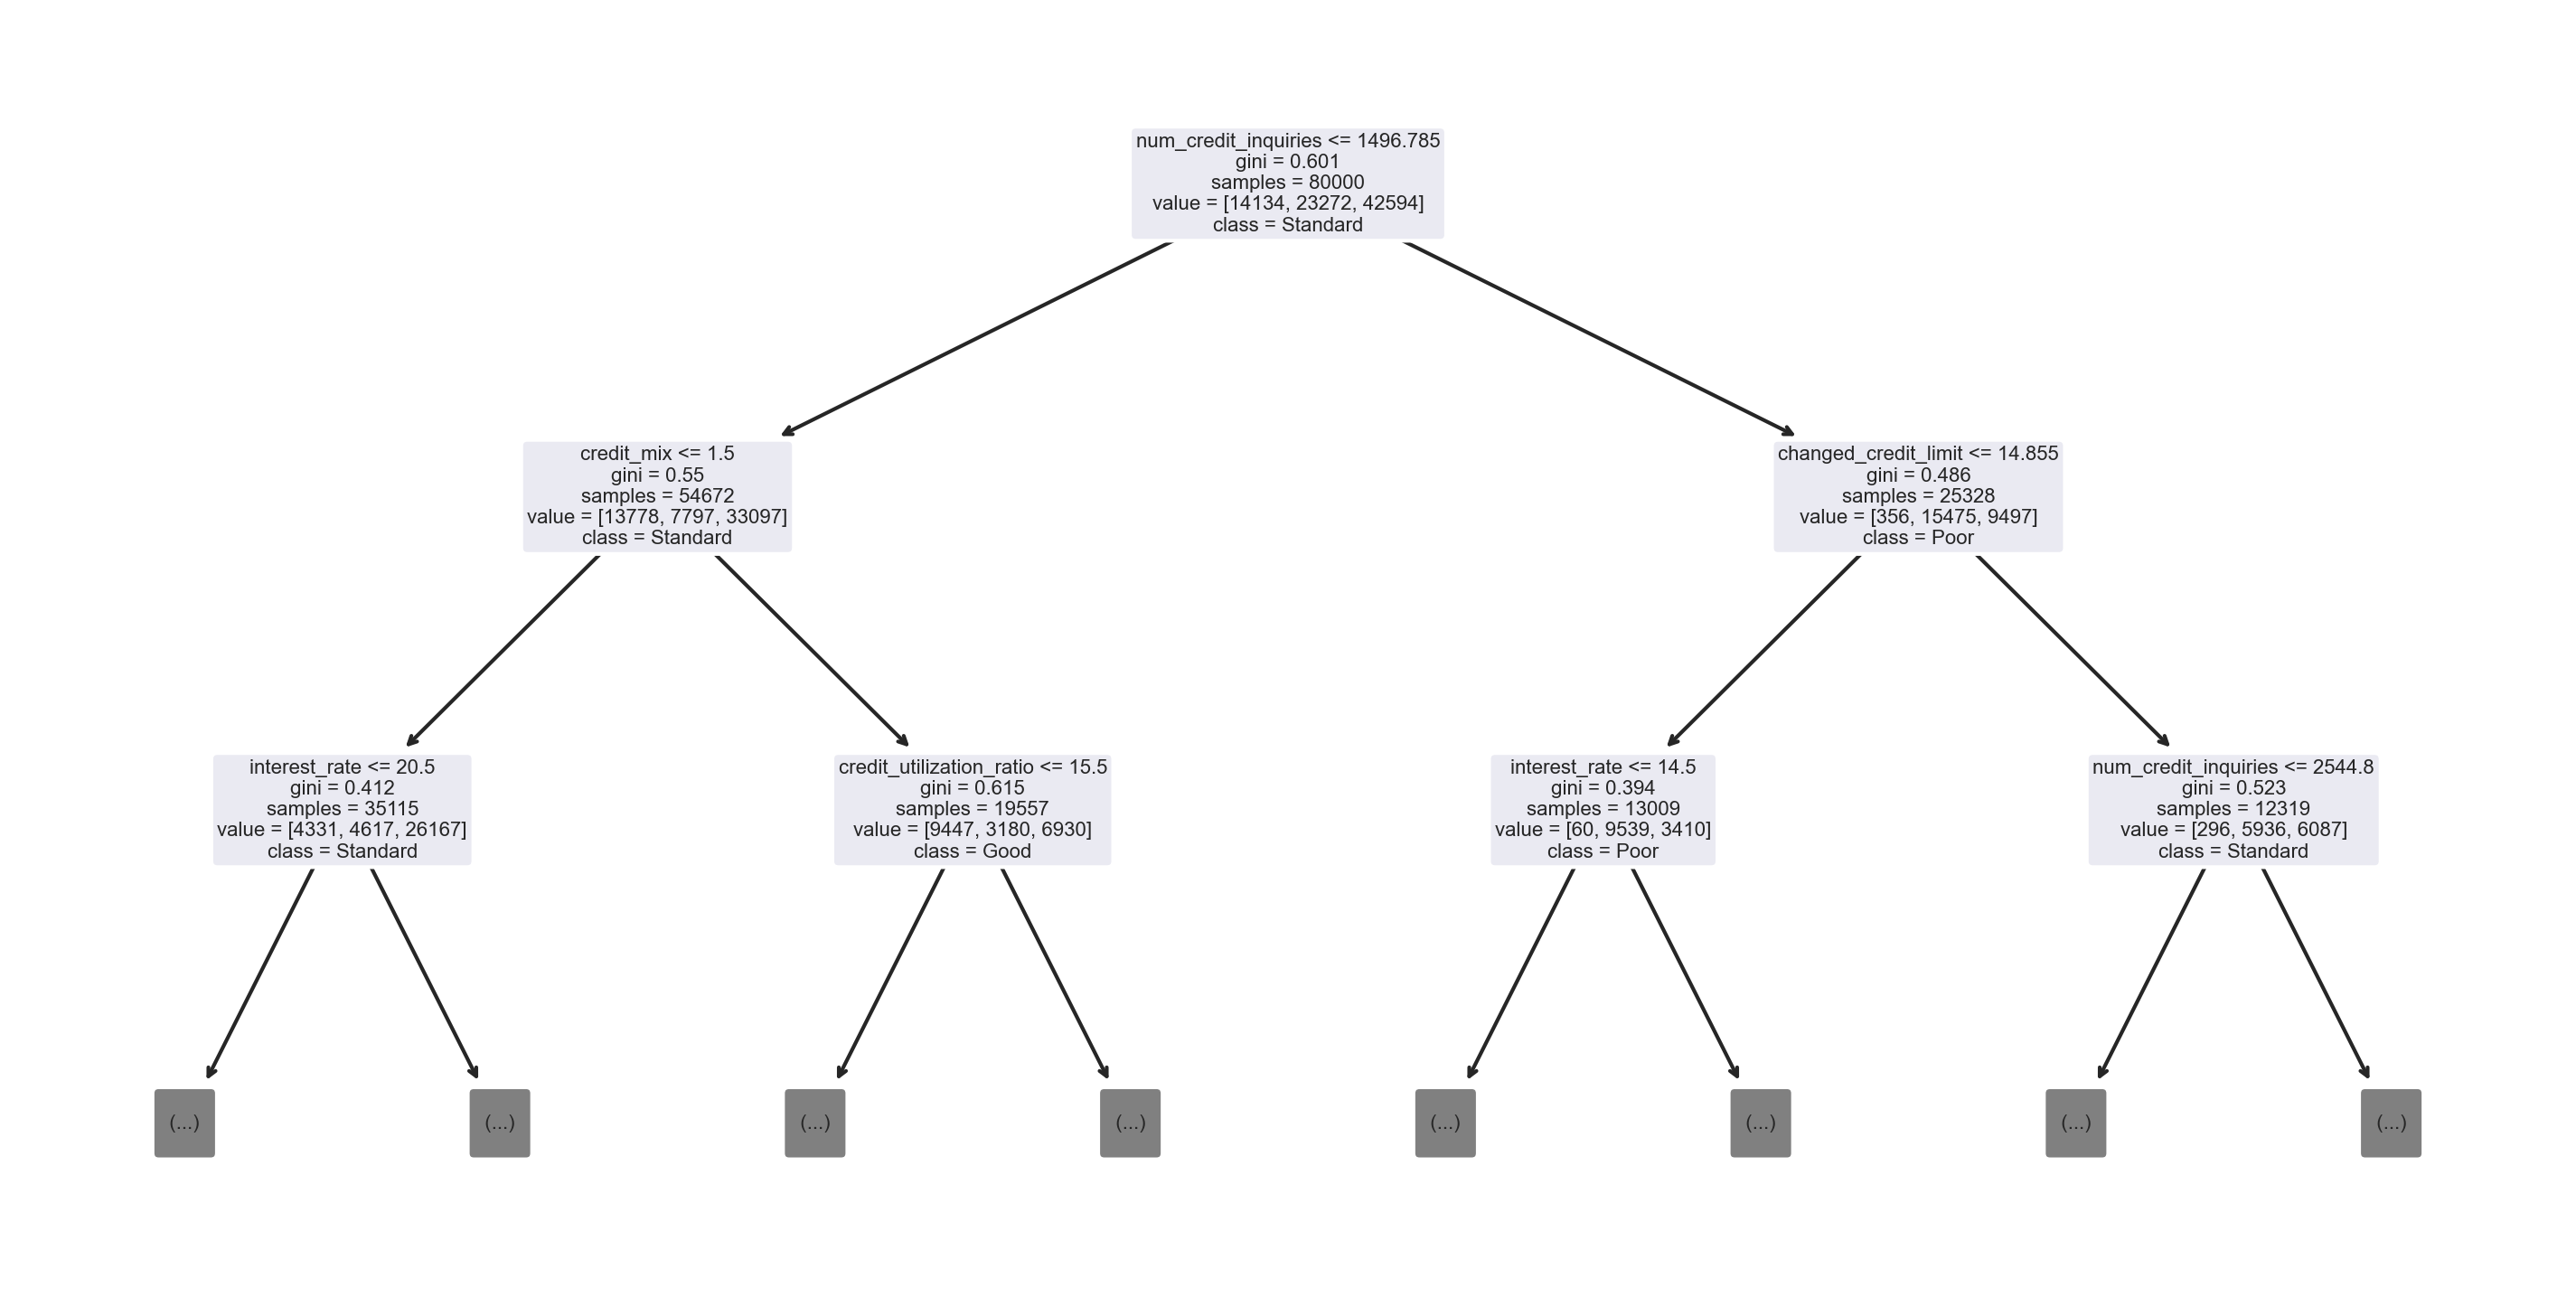

In [25]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
plot_tree(classifier, max_depth=2, feature_names=X_train_transformed.columns, class_names=classifier.classes_, rounded=True, ax=ax)
plt.show()

In [27]:
y_pred_train = classifier.predict(X_train_transformed)
y_pred_test = classifier.predict(X_test_transformed)
y_pred_train

array(['Standard', 'Standard', 'Standard', ..., 'Standard', 'Good',
       'Good'], dtype=object)

<div class="alert alert-info">
  <h1><center>Evaluation</center></h1></div>

## Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from functools import partial

In [29]:
confusion_matrix(y_train, y_pred_train)

array([[14134,     0,     0],
       [    0, 23272,     0],
       [    0,     0, 42594]], dtype=int64)

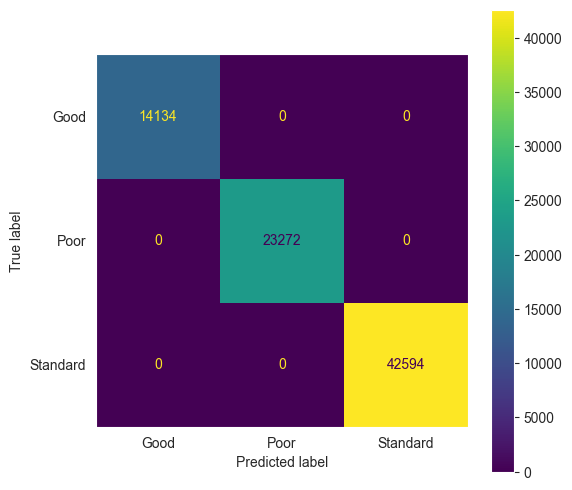

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, ax=ax)
ax.grid(False)
plt.show()

In [32]:
def compare_train_test_confusion_matrix(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4))
    cm = partial(ConfusionMatrixDisplay.from_estimator, estimator=model, colorbar=False, values_format=",.3f", normalize="pred")
    cm(X=X_train, y=y_train, ax=ax1)
    cm(X=X_test, y=y_test, ax=ax2)
    ax1.set_title("Train")
    ax2.set_title("Test")
    ax1.grid(False)
    ax2.grid(False)
    plt.suptitle("DecisionTreeClassifier performace on Seen and Unseed data")
    plt.show()

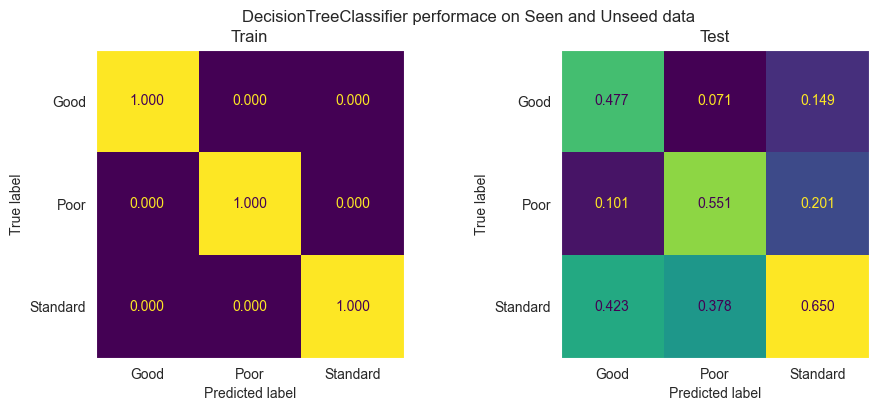

In [33]:
compare_train_test_confusion_matrix(classifier, X_train_transformed, y_train, X_test_transformed, y_test)

#### >> Restricted Decision Tree Classifier

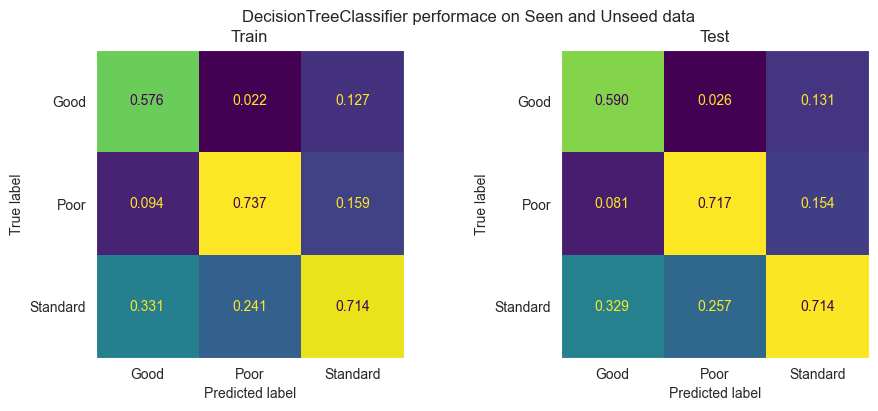

In [34]:
restricted_classifier = DecisionTreeClassifier(random_state=1, max_depth=6, min_samples_leaf=50)
compare_train_test_confusion_matrix(restricted_classifier, X_train_transformed, y_train, X_test_transformed, y_test)

In [40]:
y_pred_train_restricted = restricted_classifier.predict(X_train_transformed)
y_pred_test_restricted = restricted_classifier.predict(X_test_transformed)

---

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [45]:
def compare_train_test_metrics(metric_func, y_train, pred_train, y_test, pred_test):
    print(f"Train score: {metric_func(y_train, pred_train):,.3f}")
    print(f"Test score: {metric_func(y_test, pred_test):,.3f}")

## Accuracy

In [35]:
from sklearn.metrics import accuracy_score

In [46]:
compare_train_test_metrics(accuracy_score, y_train, y_pred_train_restricted, y_test, y_pred_test_restricted)

Train score: 0.696
Test score: 0.693


## Precision, Recall and F1-score

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [145]:
precision_score(y_true=y_test, y_pred=model_restricted.predict(X_test_transformed), average="weighted")

0.6937176310320295

#### Precision

In [47]:
compare_train_test_metrics(partial(precision_score, average="weighted"), y_train, y_pred_train_restricted, y_test, y_pred_test_restricted)

Train score: 0.696
Test score: 0.692


#### Recall

In [48]:
compare_train_test_metrics(partial(recall_score, average="weighted"), y_train, y_pred_train_restricted, y_test, y_pred_test_restricted)

Train score: 0.696
Test score: 0.693


#### F1-score

In [49]:
compare_train_test_metrics(partial(f1_score, average="weighted"), y_train, y_pred_train_restricted, y_test, y_pred_test_restricted)

Train score: 0.694
Test score: 0.692


## Classification report

In [51]:
from sklearn.metrics import classification_report

print(f"< Train >".center(53, "-"))
print(classification_report(y_train, y_pred_train_restricted))
print(f"< Test >".center(53, "-"))
print(classification_report(y_test, y_pred_test_restricted))

----------------------< Train >----------------------
              precision    recall  f1-score   support

        Good       0.58      0.55      0.56     14134
        Poor       0.74      0.63      0.68     23272
    Standard       0.71      0.78      0.75     42594

    accuracy                           0.70     80000
   macro avg       0.68      0.65      0.66     80000
weighted avg       0.70      0.70      0.69     80000

-----------------------< Test >----------------------
              precision    recall  f1-score   support

        Good       0.59      0.56      0.58      3694
        Poor       0.72      0.65      0.68      5726
    Standard       0.71      0.77      0.74     10580

    accuracy                           0.69     20000
   macro avg       0.67      0.66      0.66     20000
weighted avg       0.69      0.69      0.69     20000



## Precision-Recall and ROC plot

#### Binary model

In [55]:
binary_y_train = (y_train == "Good").astype(int)
binary_y_test = (y_test == "Good").astype(int)

In [62]:
binary_classifier = DecisionTreeClassifier(max_depth=7, min_samples_leaf=50)
binary_classifier.fit(X_train_transformed, binary_y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=50)

In [86]:
binary_pred_train = binary_classifier.predict(X_train_transformed)
binary_pred_test = binary_classifier.predict(X_test_transformed)

binary_prob_train = binary_classifier.predict_proba(X_train_transformed)[:, 1]
binary_prob_test = binary_classifier.predict_proba(X_test_transformed)[:, 1]

In [64]:
print(f"< Train >".center(53, "-"))
print(classification_report(binary_y_train, binary_pred_train))
print(f"< Test >".center(53, "-"))
print(classification_report(binary_y_test, binary_pred_test))

----------------------< Train >----------------------
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     65866
           1       0.62      0.52      0.57     14134

    accuracy                           0.86     80000
   macro avg       0.76      0.73      0.74     80000
weighted avg       0.85      0.86      0.85     80000

-----------------------< Test >----------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     16306
           1       0.60      0.52      0.55      3694

    accuracy                           0.85     20000
   macro avg       0.75      0.72      0.73     20000
weighted avg       0.84      0.85      0.84     20000



#### Precision-Recall

In [72]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

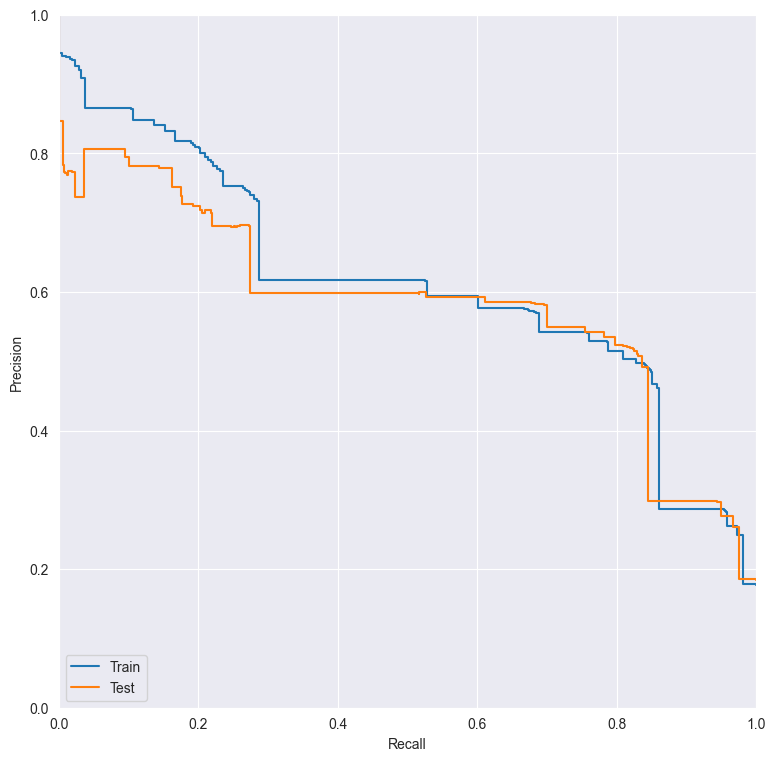

In [95]:
train_precision, train_recall, _ = precision_recall_curve(binary_y_train, binary_prob_train)
test_precision, test_recall, _ = precision_recall_curve(binary_y_test, binary_prob_test)

fig, ax = plt.subplots(figsize=(9, 9))
train_pr = PrecisionRecallDisplay(train_precision, train_recall, estimator_name="Train")
test_pr = PrecisionRecallDisplay(test_precision, test_recall, estimator_name="Test")
train_pr.plot(ax=ax)
test_pr.plot(ax=ax)
ax.grid(True)
ax.set(xlim=[0, 1], ylim=[0, 1])
plt.show()

#### ROC

In [82]:
from sklearn.metrics import roc_curve, RocCurveDisplay

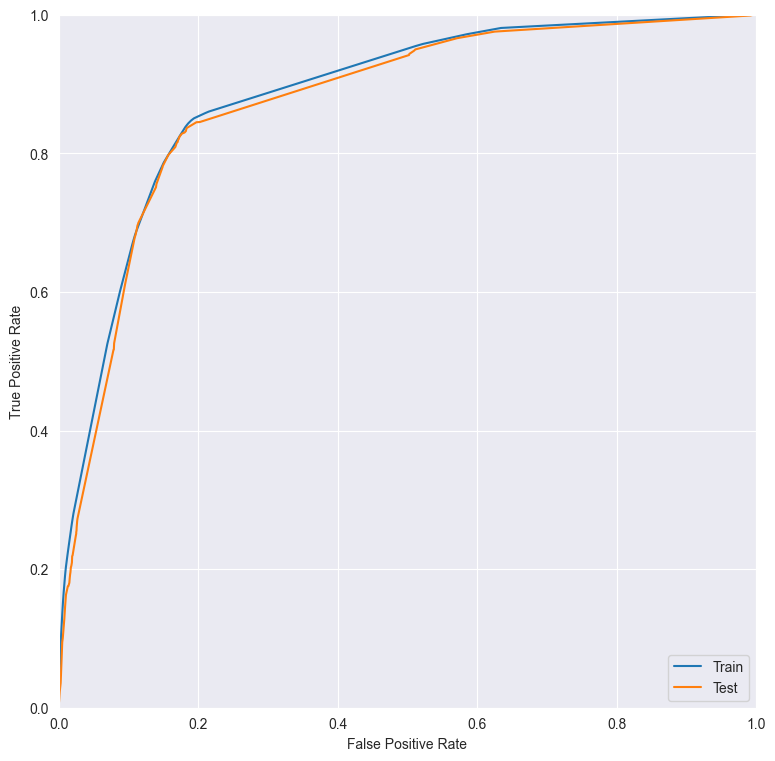

In [94]:
train_fpr, train_tpr, _ = roc_curve(binary_y_train, binary_prob_train)
test_fpr, test_tpr, _ = roc_curve(binary_y_test, binary_prob_test)

fig, ax = plt.subplots(figsize=(9, 9))
train_roc = RocCurveDisplay(fpr=train_fpr, tpr=train_tpr, estimator_name="Train")
test_roc = RocCurveDisplay(fpr=test_fpr, tpr=test_tpr, estimator_name="Test")
train_roc.plot(ax=ax)
test_roc.plot(ax=ax)
ax.grid(True)
ax.set(xlim=[0, 1], ylim=[0, 1])
plt.show()

## Gain Plot

In [101]:
def create_dataset_for_GainPlot(fact: pd.Series, prob: np.ndarray) -> pd.DataFrame:
    df = pd.DataFrame({"fact": fact, "prob": prob}, index=fact.index)
    df = df.sort_values("prob", ascending=False)
    df["recall"] = df["fact"].cumsum() / df["fact"].sum()
    df["coverage"] = np.arange(1, 1+ len(df)) / len(df)
    return df

In [104]:
train_results = create_dataset_for_GainPlot(fact=binary_y_train, prob=binary_prob_train)
test_results = create_dataset_for_GainPlot(fact=binary_y_test, prob=binary_prob_test)
test_results

fact      prob    recall  coverage
customer_id month                                    
CUS_0x71c1  1         0  0.945205  0.000000   0.00005
            4         1  0.945205  0.000271   0.00010
CUS_0x4e30  3         1  0.945205  0.000541   0.00015
            7         1  0.945205  0.000812   0.00020
CUS_0x40fa  2         1  0.945205  0.001083   0.00025
...                 ...       ...       ...       ...
CUS_0x9dc3  4         0  0.003690  1.000000   0.99980
            3         0  0.003690  1.000000   0.99985
CUS_0x9d04  6         0  0.003690  1.000000   0.99990
            5         0  0.003690  1.000000   0.99995
CUS_0x9a2c  7         0  0.003690  1.000000   1.00000

[20000 rows x 4 columns]

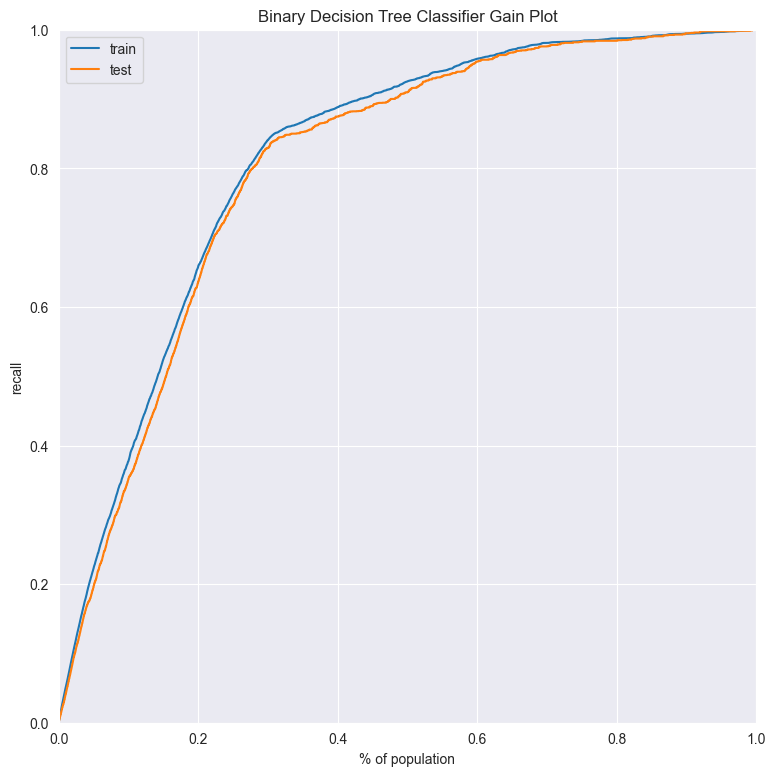

In [107]:
fig, ax = plt.subplots(figsize=(9, 9))
_ = ax.plot(train_results["coverage"], train_results["recall"], label="train")
_ = ax.plot(test_results["coverage"], test_results["recall"], label="test")
ax.grid(True)
ax.legend(loc="upper left")
ax.set(xlim=[0, 1], ylim=[0, 1], title="Binary Decision Tree Classifier Gain Plot", xlabel="% of population", ylabel="recall")
plt.show()

---

<div class="alert alert-info">
  <h1><center>Decision Tree Regressor</center></h1></div>

In [131]:
reg_X_train = X_train_transformed.drop(columns=["monthly_balance"])
reg_y_train = X_train_transformed['monthly_balance']
reg_X_test  = X_test_transformed.drop(columns=["monthly_balance"])
reg_y_test  = X_test_transformed['monthly_balance']

In [139]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [133]:
reg_model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=50)
reg_model.fit(reg_X_train, reg_y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=50)

In [ ]:
reg_model.score()

In [137]:
np.sqrt(mean_squared_error(reg_y_train, reg_model.predict(reg_X_train)))

1896.300520937107

In [138]:
np.sqrt(mean_squared_error(reg_y_test, reg_model.predict(reg_X_test)))

2387.422849423302

In [141]:
mean_absolute_percentage_error(reg_y_train, reg_model.predict(reg_X_train))

0.046541761478555314

In [142]:
mean_absolute_percentage_error(reg_y_test, reg_model.predict(reg_X_test))

0.05651095104532398